In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

### reference
- A Neural Probabilistic Language Model https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}  # 0 is reserved for padding
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}    # inverse mapping
print(f'{itos=}')

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

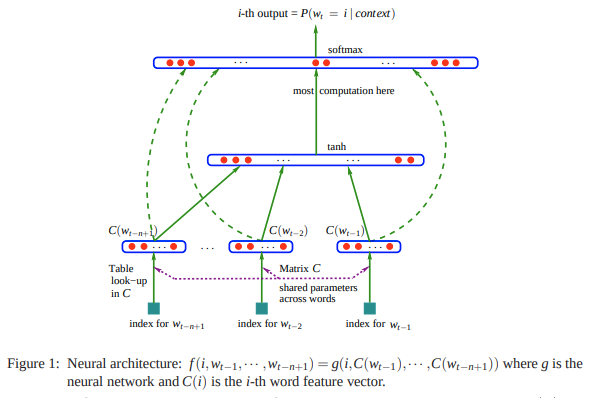

In [6]:
Image("mlp.png")

In [7]:
C = torch.randn((27, 2))    # embedding layer. 27 characters, 2 dimensions

In [8]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

### modifying dimensionalities to enable matrix multiplications

- want to do: `emb @ W1 + b1`
- but dimensions are (32,3,2) @ (6,100), which cannot matrix multiply

In [10]:
# want to concatenate the embeddings, the 3 different C input in diagram above

torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape

torch.Size([32, 6])

In [11]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [12]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [13]:
a.shape

torch.Size([18])

In [14]:
# represent a as a 3x3x2 tensor
a.view(3,3,2)

# represent a as a 2x9 tensor
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

tensor.view is efficient, it doesn't change the underlying data, just the way it's interpreted. no memory is being changed or copied

http://blog.ezyang.com/2019/05/pytorch-internals/

In [15]:
emb.view(32, 6)

# above is the same as torch.cat(torch.unbind(emb, dim=1), dim=1)

# -1 means "infer this dimension"
# tanh normalizes between -1 and 1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [16]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([32, 27])

In [19]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)

In [20]:
prob.shape

torch.Size([32, 27])

In [21]:
-prob[torch.arange(32), Y].log().mean() # negative log likelihood loss

tensor(16.5929)

### MLP

In [22]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [23]:
sum(p.nelement() for p in parameters)  # number of parameters

3481

### now lets use the full dataset

In [24]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

#   print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [25]:
for _ in range(10):
    # forward pass
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(f'{loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(f'{loss.item()=}')

loss.item()=19.505229949951172
loss.item()=17.08449363708496
loss.item()=15.776531219482422
loss.item()=14.833340644836426
loss.item()=14.002603530883789
loss.item()=13.25325870513916
loss.item()=12.579916954040527
loss.item()=11.983101844787598
loss.item()=11.47049331665039
loss.item()=11.05185604095459
loss.item()=11.05185604095459


### training split, dev/validation split, test split

- 80%, 10%, 10%

In [26]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### increase model size

In [27]:
# define the model

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [28]:
sum(p.nelement() for p in parameters)  # number of parameters

11897

### batch training

In [29]:
steps = int(50000)

lri = []
lossi = []

# learning rate decay
lre = torch.linspace(-3, 0, steps)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9997, 0.9999, 1.0000])

In [49]:
# run training loop

for i in range(steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(f'{loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())

print(f'{loss.item()=}')

loss.item()=2.2843234539031982


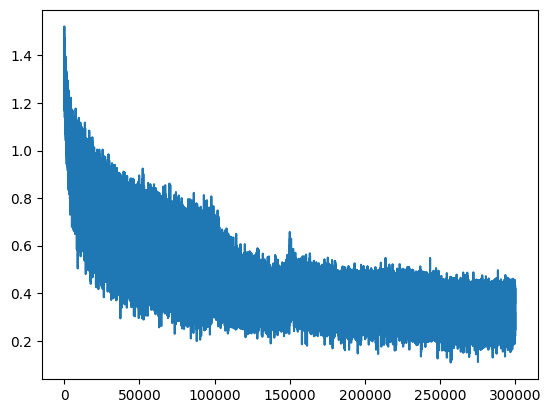

In [50]:
plt.plot(lossi)

In [45]:
# training loss

emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3536, grad_fn=<NllLossBackward0>)

In [46]:
# dev loss

emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3880, grad_fn=<NllLossBackward0>)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

aria.
amyaz.
azel.
adyn.
alanethralendra.
galie.
adarline.
malandre.
aileananaranaleimankalin.
saddargahianna.
kandrenleelanten.
anubakardar.
yah.
amela.
kay.
avannalaihal.
aadyansun.
zakalaylanna.
ravis.
jaoag.


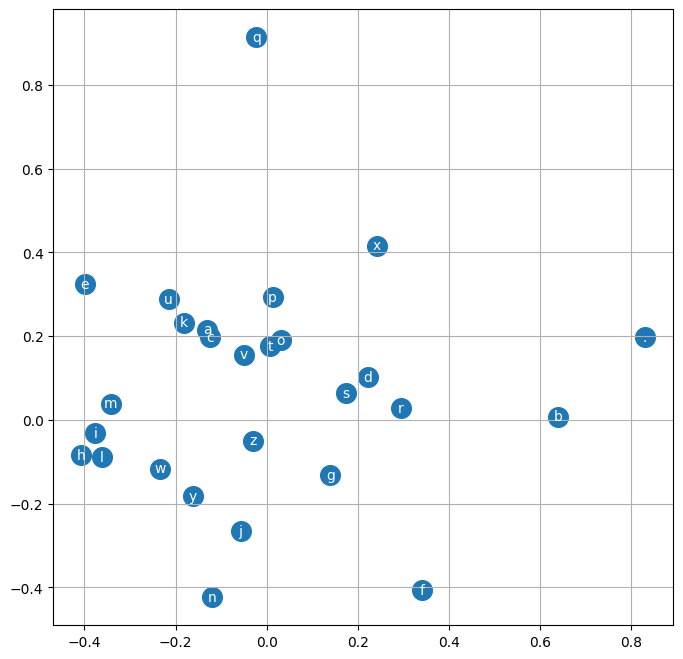

In [48]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### how to determine learning rate

- https://youtu.be/TCH_1BHY58I?feature=shared&t=2762 ~46:00
- find bounds betwee: 1) max value where it oscillates and explodes, 2) min value where it's learning too slow
- use torch.linspace:
  - torch.linspace(-3, 0, 1000)  # step linearly between 0.001 and 1 over 1000 steps
  - 10**lre  # stepping linearly through exponents

ValueError: x and y must have same first dimension, but have shapes (0,) and (50000,)

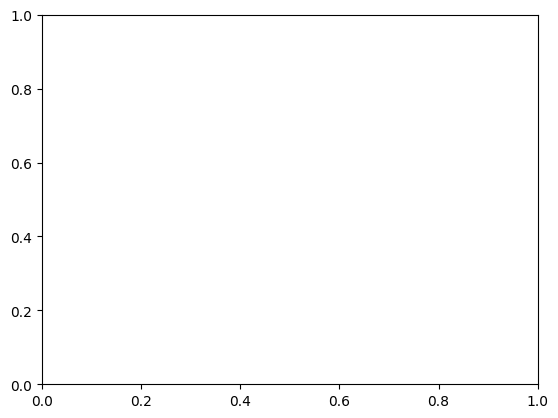

In [36]:
plt.plot(lri, lossi)

# find min on plot below to find best learning rate